In [4]:
#warning 숨기기
import warnings
warnings.filterwarnings('ignore')

In [ ]:
##나눔 글꼴 설치
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf
#
##설치후 상단에서 런타임 - 런타임 다시 시작

In [5]:
# matplotlib을 사용하는 모든 plot에 나눔 글꼴 적용
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [6]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 1. 데이터 전처리

데이터 불러오기

In [74]:
train=pd.read_csv('./data/train.csv')
test=pd.read_csv('./data/test.csv')
data=pd.concat([train, test], axis=0)

In [75]:
data = data.reset_index(drop=True)

### 2.1 기존 변수 활용

일자 관련 변수: 년도, 월, 일, 요일




In [76]:
year=[]
for i in range(len(data['일자'])) :
  year.append(data.iloc[i,0][0:4])
data['year']=year

In [77]:
mon=[]
for i in range(len(data['일자'])) :
  mon.append(data.iloc[i,0][5:7])
data['월']=mon

In [78]:
date=[]
for i in range(len(data['일자'])) :
  date.append(data.iloc[i,0][8:10])
data['date']=date

In [79]:
yoil=[]
for i in range(len(data)) : 
  if data.iloc[i,1]=='월' : yoil.append(0)
  if data.iloc[i,1]=='화' : yoil.append(1)
  if data.iloc[i,1]=='수' : yoil.append(2)
  if data.iloc[i,1]=='목' : yoil.append(3)
  if data.iloc[i,1]=='금' : yoil.append(4)
data['요일']=yoil

In [80]:
# 랜덤포레스트에서 categorical로 처리하기 위해 데이터 형변환
data['date']=data['date'].astype(int)
data['월']=data['월'].astype(int)
data['year']=data['year'].astype(int)

In [81]:
#필요한 컬럼 선택
data=data[['일자','year', '월', 'date', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계']]


공휴일 관련 변수(Under, Over, Holiday, Vacation)

:공휴일이나 명절에 따라 식수 인원이 변할 수 있다고 판단되어,
총 휴일의 길이나, 휴일이 언제 시작되는지에 따라 수기로 표기함.

규칙: 
- (주말포함) 3일 이상 휴일인 경우 vacation, 그 외에는 holiday로 표기
- 해당 휴일까지 남은 기간은 –n 일로, 지난 기간은 +n일로 표기
- 휴일이 시작 / 끝나는 주에 한정하여 표기.
- 단, 월요일 하루만 휴가인 경우, 그 전 주까지 기간을 표기.
- Holiday 또는 vacation에 -1이 표기되어 있을 경우 Under에 1, 그 외의 경우는 Over에 1 표기.
- 위의 경우에 해당하지 않는 경우, Under, over, Holiday, Vacation에 0으로 표기. 

In [82]:
k=pd.read_csv('./data/공휴일 정리.csv', encoding='cp949')
k=k.fillna(0)
data['under']=k['under']
data['over']=k['over']
data['holiday']=k['holiday']
data['vacation']=k['vacation']

문화의날 변수

In [83]:
munhwa=[]
for i in range(len(data)) : 
  if len(data.loc[i,'석식메뉴']) < 25 : 
    munhwa.append(1)  
  else : munhwa.append(0)
data['zerodinner']=munhwa

메뉴 관련 변수

In [84]:
menu=pd.read_csv('./data/LH 반찬 메뉴정리.csv', encoding='cp949')
menu=menu.drop(['비고1','비고2','Unnamed: 24','Din_비고1','석식메뉴','Din_비고2','Din_비고2','석식메뉴.1'], axis=1)
menu=menu.fillna(0)
menu=menu.rename(columns={'Date' : '일자'})
data=pd.merge(data,menu, on='일자', how='left')


### 신규 데이터 추가

부동산, LH 미디어, 코로나 확진자 수, 공휴일, 문화의 날, 불쾌지수, 강수량 데이터 추가
* 부동산_미디어지수 : 전 날 부동산 뉴스 건수 (출처 : 빅카인즈)
* LH_미디어지수 : 전 날 LH 뉴스 건수 (출처 : 빅카인즈, https://www.bigkinds.or.kr/v2/news/index.do)

ex. 2016년 2월 1일 란에는 1월 31일 자 뉴스 건수

* 코로나 : 코로나 확진자 수, test set -> 전 날까지의 확진자 수를 바탕으로 ARIMA 모델 이용하여 예측

(출처 : https://ourworldindata.org/coronavirus#testing-for-covid-19)


*   문화의 날 : 석식계가 0인 경우에 1, 그 외는 0으로 표기.


* 불쾌지수 : train set -> 과거 일기 기록, test set -> 전 날 일기예보

(출처 : 기상자료개방포털, https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
머니투데이 https://search.mt.co.kr/?srchFd=TOTAL&range=TOTAL&category=TOTAL&reSrchFlag=&preKwd=&search_type=m&mode=&code=&kwd=%B3%BB%C0%CF+%B3%AF%BE%BE
연합뉴스 https://www.yna.co.kr/search/index?query=%EB%82%B4%EC%9D%BC%EB%82%A0%EC%94%A8&from=20210126&to=20210408&period=diy
종합 기후변화감시정보 http://www.climate.go.kr/home/09_monitoring/vapor/relativehumidity)


* 강수량 데이터 : train set -> 과거 강수 기록, test set -> 전 날 일기예보 

(출처 : 기상자료개방포털, https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
머니투데이 https://search.mt.co.kr/?srchFd=TOTAL&range=TOTAL&category=TOTAL&reSrchFlag=&preKwd=&search_type=m&mode=&code=&kwd=%B3%BB%C0%CF+%B3%AF%BE%BE
연합뉴스 https://www.yna.co.kr/search/index?query=%EB%82%B4%EC%9D%BC%EB%82%A0%EC%94%A8&from=20210126&to=20210408&period=diy)

뉴스에서 '부동산' 언급된 횟수

In [85]:
realty=pd.read_csv('./data/부동산 뉴스 검색량.csv')[['date','부동산']]
realty=realty.rename(columns={'date' : '일자','부동산' : '부동산_미디어지수'})
realty['일자']=pd.to_datetime(realty['일자'],format='%Y%m%d')
realty['일자']=realty['일자'].astype(str)
data=pd.merge(data, realty, on='일자', how='left')
value=data[['부동산_미디어지수']]
value= pd.concat([pd.DataFrame({'부동산_미디어지수':[0]}),value], axis=0).reset_index(drop=True)
data[['부동산_미디어지수']] = value[:1255]
data.loc[0,'부동산_미디어지수']=realty.loc[0,'부동산_미디어지수']

뉴스에서 'LH' 언급된 횟수

In [86]:
LH=pd.read_csv('./data/LH 뉴스 검색량.csv')[['date','LH']]
LH=LH.rename(columns={'date' : '일자','LH' : 'LH_미디어지수'})
LH['일자']=pd.to_datetime(LH['일자'],format='%Y%m%d')
LH['일자']=LH['일자'].astype(str)
data=pd.merge(data, LH, on='일자', how='left')
value=data[['LH_미디어지수']]
value= pd.concat([pd.DataFrame({'LH_미디어지수':[0]}),value], axis=0).reset_index(drop=True)
data[['LH_미디어지수']] = value[:1255]
data.loc[0,'LH_미디어지수']=LH.loc[0,'LH_미디어지수']

코로나 확진자 수 예측값

In [87]:
covid=pd.read_csv('./data/전세계 코로나 확진자 수.csv', encoding='cp949')
covid_kor=covid.loc[covid.location=='South Korea'][['date','new_cases']]
covid_kor=covid_kor.rename(columns={'date' : '일자','new_cases' : 'corona'})
covid_kor['일자']= pd.to_datetime(covid_kor['일자'],format='%Y-%m-%d')
covid_train=covid_kor.loc[covid_kor.일자 < '2021-01-27' ]
covid_test=covid_kor.loc[(covid_kor.일자 >= '2021-01-27') & (covid_kor.일자 <= '2021-04-10') ]
covid_pred=covid_test['일자']

covid_train=covid_train.fillna(0)

In [68]:
corona_pridiction=[]
for i in range(len(covid_test)) :
  covid_train=covid_kor.loc[ 87832 : 88203+ i, ['일자','corona'] ]
  covid_train=covid_train.fillna(0)
  #auto = auto_arima(covid_train['corona']).order
  model = ARIMA(covid_train['corona'].values, order=(1,0,6)) #4191
  fit_model = model.fit(trend='c', full_output=True, disp=True)
  forcast = fit_model.forecast(steps=1)
  corona_pridiction.append(forcast[0].tolist()[0])

In [88]:
covid_test['corona'] = corona_pridiction
covid_train = covid_train.reset_index(drop=True)
covid_test = covid_test.reset_index(drop=True)
covid = pd.concat([covid_train, covid_test], axis=0 ,ignore_index=True).reset_index(drop=True)
covid['일자'] = covid['일자'].astype('str')
data = pd.merge(data, covid, how='left', on='일자')
data['corona'] = data['corona'].fillna(0)
data = data.reset_index(drop=True)

불쾌지수와 강수량

: 불쾌지수 계산에 필요한 온도, 습도, 강수량은 전 날 예보를 통해 수기로 입력
습도는 비가 올 경우 월 평균에서 +20%, 맑은 날일 경우 -20%로 예측

(1월 평균 : 61.2, 2월 평균 : 62, 3월 평균 : 62, 4월 평균 : 61.7) 

In [89]:
temp=pd.read_csv('./data/16년부터 21년까지 기온.csv', encoding='cp949')
humid=pd.read_csv('./data/16년부터 21년까지 습도.csv', encoding='cp949')
angry=[]
for i in range(len(temp)):
  t=temp.iloc[i,3]
  rh=humid.iloc[i,3]
  angindex=9/5*t-0.55*(1-rh/100)*(9/5*t-26)+32
  angry.append(angindex)
temp['불쾌지수']=angry
temp=temp.rename(columns={'일시' : '일자'})
data=pd.merge(data,temp.iloc[:,[2,9]], on='일자', how='left')


rain=pd.read_csv('./data/16년부터 21년도 강수량.csv', encoding='cp949')
rain=rain.rename(columns={'일시' : '일자', '강수량(mm)' : 'rain'})
rain=rain.iloc[:,[2,3]]
rain=rain.fillna(0)
data=pd.merge(data,rain, on='일자', how='left')
test_humid=data.loc[data['중식계'].isna(),'불쾌지수']
data.loc[data['중식계'].isna(),'불쾌지수']=0
data.loc[data['중식계'].isna(),'rain']=0

In [90]:
temp_test=pd.DataFrame({'temp':[5, 4.5, -2.5,9,0.5,0.5,4.5,3.5,1.5,1.5,4.5,9.5,2.5,-2,-1,3.5,14.5,4.5,5.5,7,8.5,6.5,5,8.5,11.5,8,9,10,9.5,10,10.5,13.5,10.5,11.5,11,8,9.5,10.5,13.5,14.5,15.5,14.5,13.5,13.5,16,16.5,13,14.5,14,11]})
rain_test=pd.DataFrame({'rain':[0,0,0,17.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,20,0,12.5,0,0,0,0,0,25,0,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]})
humid_test=pd.DataFrame({'humid':[63.1,63.1,43.1,82,42,62,62,62,42,42,42,62,62,62,62,42,42,42,62,82,82,82,42,82,62,42,62,42,62,82,62,82,42,42,42,42,42,42,42,42,42,42,42,61.7,61.7,41.7,61.7,41.7,41.7,41.7]})
angry_test=[]
for i in range(len(temp_test)):
  t=temp_test.iloc[i,0]
  rh=humid_test.iloc[i,0]
  angindex=9/5*t-0.55*(1-rh/100)*(9/5*t-26)+32
  angry_test.append(angindex)
temp_test['불쾌지수']=angry_test
data.loc[data['중식계'].isna(),'불쾌지수']=angry_test
data.loc[data['중식계'].isna(),'rain']=np.array(rain_test['rain'])


### 변수 변환

In [91]:
train = data.loc[~data['중식계'].isna(),]
test = data.loc[data['중식계'].isna(),]

In [92]:
start_data=data
start_trian=train

In [93]:
def scailing(x,xs) :
  re=[]
  ave=xs.mean()
  sig=xs.std()
  for i in range(len(x)) :
    re.append((x.iloc[i]-ave)/sig)
  return(re)

In [94]:
def zerone(x) :
  re=[]
  for i in range(len(x)) :
    if x[i]==0 : re.append(0) 
    else : re.append(1)
  return(re)

log 변환

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


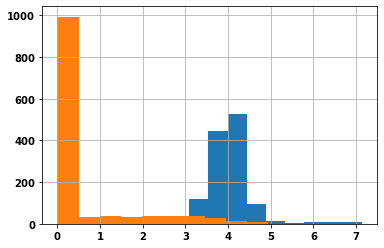

In [95]:
data['본사정원수']=scailing(data['본사정원수'],start_trian['본사정원수'])

y=data['본사휴가자수']
ylog=[]
for i in range(len(y)) :
  ylog.append(math.log(y.iloc[i]))
data['본사휴가자수']=ylog
data['본사휴가자수']=scailing(data['본사휴가자수'],start_trian['본사휴가자수'])
data['본사출장자수']=scailing(data['본사출장자수'],start_trian['본사출장자수'])
data['본사시간외근무명령서승인건수']=scailing(data['본사시간외근무명령서승인건수'],start_trian['본사시간외근무명령서승인건수'])

y=data['부동산_미디어지수']
ylog=[]
for i in range(len(y)) :
  ylog.append(math.log(y.iloc[i]))
data['부동산_미디어지수']=ylog

y=data['LH_미디어지수']
ylog=[]
for i in range(len(y)) :
  ylog.append(math.log(y.iloc[i]))
data['LH_미디어지수']=ylog
data['LH_미디어지수'].hist()

y=data['rain']
ylog=[]
for i in range(len(y)) :
  ylog.append(math.log(y.iloc[i]+1))
data['rain']=ylog
data['rain'].hist()

y=data['corona']
ylog=[]
for i in range(len(y)) :
  ylog.append(math.log(y.iloc[i]+1))
data['corona']=ylog


Scaling - Standardization

In [96]:
data['부동산_미디어지수']=scailing(data['부동산_미디어지수'],start_trian['부동산_미디어지수'])
data['LH_미디어지수']=scailing(data['LH_미디어지수'],start_trian['LH_미디어지수'])
data['불쾌지수']=scailing(data['불쾌지수'],start_trian['불쾌지수'])
data['rain']=scailing(data['rain'],start_trian['rain'])
data['corona']=scailing(data['corona'],start_trian['corona'])

zeroone

In [97]:
data['현본사소속재택근무자수']=zerone(data['현본사소속재택근무자수'])

In [98]:
train = data.loc[~data['중식계'].isna(),]
test = data.loc[data['중식계'].isna(),]
train_Y_lunch = train.loc[:,'중식계']
train_Y_dinner = train.loc[:,'석식계']
train_X = train.drop(['중식계','석식계','일자','조식메뉴','중식메뉴','석식메뉴','Beef_Fork2', 'Chicken_Duck2', 'Seafood2', 'etc_Gredient2', 'Fried2', 'Basak_Fried2', 'Steamed2', 'Grilled2', 'etc_method2','Din_Beef_Fork2', 'Din_Chicken_Duck2', 'Din_Seafood2', 'Din_etc_Gredient2', 'Din_Fried2', 'Din_Basak_Fried2', 'Din_Steamed2', 'Din_Grilled2', 'Din_etc_method2'],axis=1)
test_X = test.drop(['중식계','석식계','일자','조식메뉴','중식메뉴','석식메뉴','Beef_Fork2', 'Chicken_Duck2', 'Seafood2', 'etc_Gredient2', 'Fried2', 'Basak_Fried2', 'Steamed2', 'Grilled2', 'etc_method2','Din_Beef_Fork2', 'Din_Chicken_Duck2', 'Din_Seafood2', 'Din_etc_Gredient2', 'Din_Fried2', 'Din_Basak_Fried2', 'Din_Steamed2', 'Din_Grilled2', 'Din_etc_method2'],axis=1)

# 시각화

<AxesSubplot:>

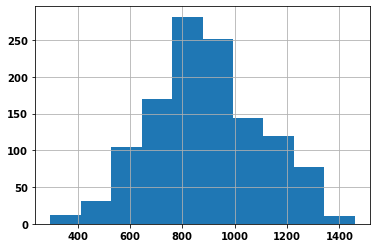

In [99]:
train['중식계'].hist()

<AxesSubplot:>

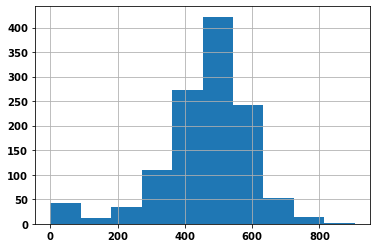

In [100]:
train['석식계'].hist()

In [102]:
!pip install pygam
from pygam import LinearGAM, s, f

In [104]:
gam = LinearGAM(s(0)).fit(train_X, train_Y_lunch) 

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


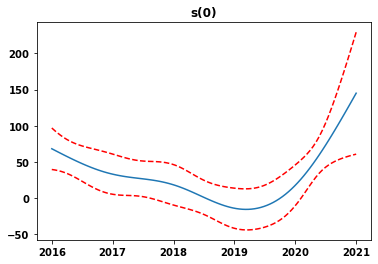

In [105]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [106]:
gam = LinearGAM(s(1)).fit(train_X, train_Y_lunch) 

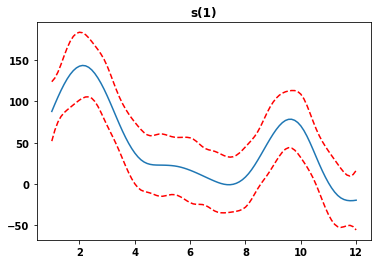

In [107]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [108]:
gam = LinearGAM(s(0)).fit(train_X, train_Y_dinner) 

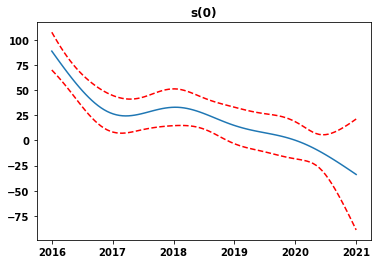

In [109]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [110]:
gam = LinearGAM(s(1)).fit(train_X, train_Y_dinner) 

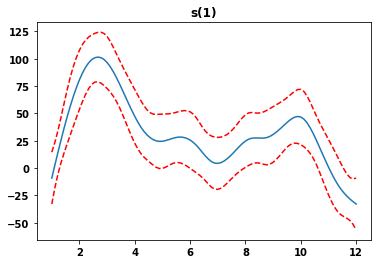

In [111]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

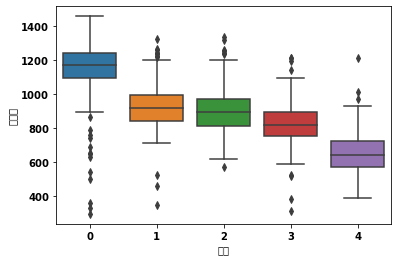

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x="요일", y="중식계", data=train)
plt.show()

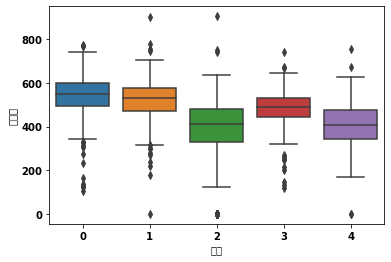

In [113]:
sns.boxplot(x="요일", y="석식계", data=train)
plt.show()

In [114]:
train.corr()[['중식계','석식계']]

,중식계,석식계
year,-0.078804,-0.194792
월,-0.154664,-0.127142
date,-0.097392,-0.185565
요일,-0.731563,-0.312112
본사정원수,-0.115529,-0.173852
본사휴가자수,-0.381265,-0.291379
본사출장자수,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.535611,0.571168
현본사소속재택근무자수,0.000747,-0.111750
중식계,1.000000,0.508287


# GAM 모델1

In [117]:
data=data[['일자','요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계','부동산_미디어지수', 'LH_미디어지수', 'corona', 'under', 'over', 'holiday',
       'vacation', 'zerodinner', '불쾌지수', 'rain', 'special_밥', 'spicy',
       'protein', 'Beef_Fork1', 'Chicken_Duck1', 'Seafood1', 'etc_Gredient1',
       'Fried1', 'Basak_Fried1', 'Steamed1', 'Grilled1', 'etc_method1',
       'Beef_Fork2', 'Chicken_Duck2', 'Seafood2', 'etc_Gredient2', 'Fried2',
       'Basak_Fried2', 'Steamed2', 'Grilled2', 'etc_method2', 'Din_Beef_Fork1',
       'Din_Chicken_Duck1', 'Din_Seafood1', 'Din_etc_Gredient1', 'Din_Fried1',
       'Din_Basak_Fried1', 'Din_Steamed1', 'Din_Grilled1', 'Din_etc_method1',
       'Din_Beef_Fork2', 'Din_Chicken_Duck2', 'Din_Seafood2',
       'Din_etc_Gredient2', 'Din_Fried2', 'Din_Basak_Fried2', 'Din_Steamed2',
       'Din_Grilled2', 'Din_etc_method2','월', 'date','year']]

In [118]:
train = data.loc[~data['중식계'].isna(),]
test = data.loc[data['중식계'].isna(),]
train_Y_lunch = train.loc[:,'중식계']
train_Y_dinner = train.loc[:,'석식계']
train_X = train.drop(['중식계','석식계','일자','조식메뉴','중식메뉴','석식메뉴','Beef_Fork2', 'Chicken_Duck2', 'Seafood2', 'etc_Gredient2', 'Fried2', 'Basak_Fried2', 'Steamed2', 'Grilled2', 'etc_method2','Din_Beef_Fork2', 'Din_Chicken_Duck2', 'Din_Seafood2', 'Din_etc_Gredient2', 'Din_Fried2', 'Din_Basak_Fried2', 'Din_Steamed2', 'Din_Grilled2', 'Din_etc_method2'],axis=1)
test_X = test.drop(['중식계','석식계','일자','조식메뉴','중식메뉴','석식메뉴','Beef_Fork2', 'Chicken_Duck2', 'Seafood2', 'etc_Gredient2', 'Fried2', 'Basak_Fried2', 'Steamed2', 'Grilled2', 'etc_method2','Din_Beef_Fork2', 'Din_Chicken_Duck2', 'Din_Seafood2', 'Din_etc_Gredient2', 'Din_Fried2', 'Din_Basak_Fried2', 'Din_Steamed2', 'Din_Grilled2', 'Din_etc_method2'],axis=1)

In [120]:
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(7)+s(11)+s(12)+s(15)+f(16)+s(37)+s(38)+f(39)).fit(train_X, train_Y_lunch) #+ s(8)

In [121]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     117.858
Link Function:                     IdentityLink Log Likelihood:                                -11708.2521
Number of Samples:                         1205 AIC:                                              23654.22
                                                AICc:                                           23680.4767
                                                GCV:                                             8014.2594
                                                Scale:                                           6616.9185
                                                Pseudo R-Squared:                                   0.8639
Feature Function                  Lam

In [122]:
lams=[0.6]*10

In [123]:
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4)+s(11)+s(12)+s(15)+s(37)+f(39),lam=lams).fit(train_X, train_Y_lunch) # + s(8)

In [124]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     91.0152
Link Function:                     IdentityLink Log Likelihood:                                -11732.8897
Number of Samples:                         1205 AIC:                                            23649.8099
                                                AICc:                                           23665.2037
                                                GCV:                                             7807.3501
                                                Scale:                                              6753.6
                                                Pseudo R-Squared:                                   0.8576
Feature Function                  Lam

In [125]:
y_lunch=gam.predict(test_X)

In [126]:
model_dinner = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) +s(11)+s(12)+f(13)+s(37)+f(39)).fit(train_X, train_Y_dinner) #+ s(8)

In [127]:
model_dinner.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     81.1693
Link Function:                     IdentityLink Log Likelihood:                                -11031.1091
Number of Samples:                         1205 AIC:                                            22226.5569
                                                AICc:                                           22238.7405
                                                GCV:                                             4288.7614
                                                Scale:                                           3772.0927
                                                Pseudo R-Squared:                                   0.8182
Feature Function                  Lam

In [128]:
y_dinner=model_dinner.predict(test_X)

In [129]:
gam1 = pd.DataFrame({'중식계': y_lunch+26, '석식계':y_dinner+15})

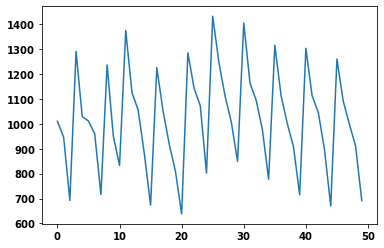

In [130]:
plt.plot(range(len(gam1['중식계'])),gam1['중식계']) 

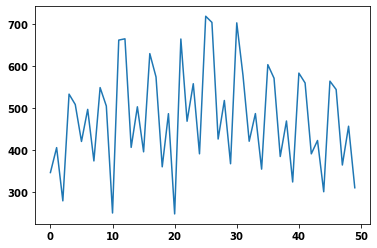

In [131]:
plt.plot(range(len(gam1['석식계'])),gam1['석식계'])

# GAM 모델2 : Penalty 변동

In [132]:
lams = [11] * 10 
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) +s(11)+s(12)+s(15)+s(37)+f(39),lam=lams).fit(train_X, train_Y_lunch) #+ s(8)

In [133]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     61.0189
Link Function:                     IdentityLink Log Likelihood:                                -11786.1109
Number of Samples:                         1205 AIC:                                            23696.2595
                                                AICc:                                           23703.1044
                                                GCV:                                             7762.7917
                                                Scale:                                           7058.5796
                                                Pseudo R-Squared:                                   0.8472
Feature Function                  Lam

In [134]:
y_lunch=gam.predict(test_X)

In [135]:
lams = [1.5]*10

In [136]:
model_dinner = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) +s(11)+s(12)+f(13)+s(37)+f(39),lam=lams).fit(train_X, train_Y_dinner)#+ s(8)
model_dinner.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     73.8542
Link Function:                     IdentityLink Log Likelihood:                                -11037.7984
Number of Samples:                         1205 AIC:                                            22225.3052
                                                AICc:                                           22235.3624
                                                GCV:                                              4260.374
                                                Scale:                                           3793.0905
                                                Pseudo R-Squared:                                    0.816
Feature Function                  Lam

In [137]:
y_dinner=model_dinner.predict(test_X)

In [138]:
gam2= pd.DataFrame({'중식계':y_lunch+20, '석식계':y_dinner+10})

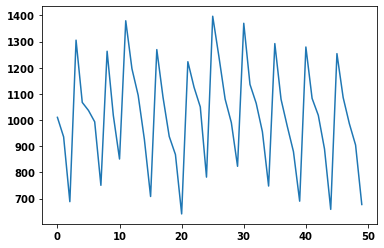

In [139]:
plt.plot(range(len(gam2['중식계'])),gam2['중식계'])

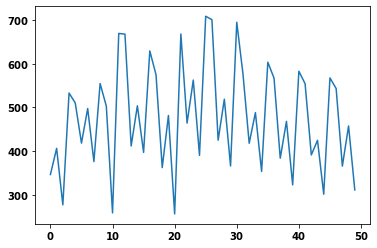

In [140]:
plt.plot(range(len(gam2['석식계'])),gam2['석식계'])

# Random Forest Model 1 - 메뉴 없이

In [141]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plot

In [142]:
data1 = data[['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '월', '불쾌지수','부동산_미디어지수', 'LH_미디어지수', 'under', 'over', 'holiday', 'vacation', 'zerodinner','중식계','석식계','일자','rain']]

In [143]:
train = data1.loc[~data1['중식계'].isna(),]
test = data1.loc[data1['중식계'].isna(),]
train_Y_lunch = train.loc[:,'중식계']
train_Y_dinner = train.loc[:,'석식계']
train_X = train.drop(['중식계','석식계','일자'],axis=1)

test_X = test.drop(['중식계','석식계','일자'],axis=1)

In [144]:
rf_model_lunch = RandomForestRegressor(random_state=535,n_estimators=110,max_depth=7)
rf_model_lunch.fit(train_X, train_Y_lunch)

RandomForestRegressor(max_depth=7, n_estimators=110, random_state=535)

예측구간에 식수인원의 증가로 인해 점심식수인원의 평균을 맞추기 위해 80을 추가함

In [145]:
rf_1_lunch = rf_model_lunch.predict(test_X)+80

In [146]:
rf_model_dinner = RandomForestRegressor(random_state=665)
rf_model_dinner.fit(train_X, train_Y_dinner)

RandomForestRegressor(random_state=665)

예측구간에 식수인원의 증가로 인해 저녁식수인원의 평균을 맞추기 위해 20을 추가함

In [147]:
rf_1_dinner = rf_model_dinner.predict(test_X)+20

In [148]:
rf1 = pd.DataFrame({'중식계':rf_1_lunch, '석식계':rf_1_dinner})

# Random Forest model 2 - 메뉴포함

In [149]:
data2 = data[['요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '월',
       '부동산_미디어지수', 'LH_미디어지수', 'under', 'over', 'zerodinner','불쾌지수',
       'special_밥', 'spicy', 'protein', 'Beef_Fork1', 'Chicken_Duck1',
       'Seafood1', 'etc_Gredient1', 'Fried1', 'Basak_Fried1', 'Steamed1',
       'Grilled1', 'etc_method1', 'Beef_Fork2', 'Chicken_Duck2', 'Seafood2',
       'etc_Gredient2', 'Fried2', 'Basak_Fried2', 'Steamed2', 'Grilled2',
       'etc_method2', 'Din_Beef_Fork1', 'Din_Chicken_Duck1', 'Din_Seafood1',
       'Din_etc_Gredient1', 'Din_Fried1', 'Din_Basak_Fried1', 'Din_Steamed1',
       'Din_Grilled1', 'Din_etc_method1', 'Din_Beef_Fork2',
       'Din_Chicken_Duck2', 'Din_Seafood2', 'Din_etc_Gredient2', 'Din_Fried2',
       'Din_Basak_Fried2', 'Din_Steamed2', 'Din_Grilled2', 'Din_etc_method2','중식계','석식계','일자','rain','corona']] #rain, 

In [150]:
train = data2.loc[~data2['중식계'].isna(),]
test = data2.loc[data2['중식계'].isna(),]
train_Y_lunch = train.loc[:,'중식계']
train_Y_dinner = train.loc[:,'석식계']
train_X = train.drop(['중식계','석식계','일자'],axis=1)

test_X = test.drop(['중식계','석식계','일자'],axis=1)

In [151]:
rf_model_lunch = RandomForestRegressor(random_state=615)
rf_model_lunch.fit(train_X, train_Y_lunch)

RandomForestRegressor(random_state=615)

예측구간에 식수인원의 증가로 인해 점심식수인원의 평균을 맞추기 위해 80을 추가함

In [152]:
rf_2_lunch = rf_model_lunch.predict(test_X)+80

In [153]:
rf_model_dinner = RandomForestRegressor(random_state=405)
rf_model_dinner.fit(train_X, train_Y_dinner)

RandomForestRegressor(random_state=405)

예측구간에 식수인원의 증가로 인해 저녁식수인원의 평균을 맞추기 위해 20을 추가함

In [154]:
rf_2_dinner = rf_model_dinner.predict(test_X)+20

In [155]:
rf2 = pd.DataFrame({'중식계':rf_2_lunch, '석식계':rf_2_dinner})

# 앙상블

In [156]:
lunch_final = (rf2['중식계']+gam1['중식계']+gam2['중식계'])/3
dinner_final = (gam1['석식계']+gam2['석식계']+rf1['석식계']+rf2['석식계'])/4

In [157]:
submit = pd.DataFrame({'중식계':lunch_final, '석식계':dinner_final})

In [158]:
submit.to_csv("submission_file_가마우지.csv")